Import libraries

In [23]:
# "standard"
import numpy as np
import pandas as pd

# Parallel computing
import dask
from dask.distributed import Client, progress

# plotting
import matplotlib.pyplot as plt
import seaborn as sns

# misc
import cv2
import magic
from IPython.display import clear_output

# Custom modules
import sys
sys.path.append('C:/Users/bedelman/Documents/GitHub/Alzheimers-MRI-Classification/src')

Load and format training data

In [35]:
BASE_DIR = "C:/Users/bedelman/Documents/GitHub/Alzheimers-MRI-Classification/data/raw/"

'''
Label meanings
0 - Mild dementia
1 - Moderate dementia
2 - No dementia
3 - Very mild dementia
'''
Lab = ['Mild', 'Moderate', 'None', 'Very Mild']

train = pd.read_parquet(f"{BASE_DIR}/train-00000-of-00001-c08a401c53fe5312.parquet", engine = "pyarrow")
train.head()

,image,label
0,{'bytes': b'\xff\xd8\xff\xe0\x00\x10JFIF\x00\x...,2
1,{'bytes': b'\xff\xd8\xff\xe0\x00\x10JFIF\x00\x...,0
2,{'bytes': b'\xff\xd8\xff\xe0\x00\x10JFIF\x00\x...,3
3,{'bytes': b'\xff\xd8\xff\xe0\x00\x10JFIF\x00\x...,3
4,{'bytes': b'\xff\xd8\xff\xe0\x00\x10JFIF\x00\x...,2


Convert data to readable format

In [39]:
import dict_to_image as dti

train['img_arr'] = train['image'].apply(dti.dict_to_image)
train.drop("image", axis=1, inplace=True)
train.head()

,label,img_arr
0,2,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,..."
1,0,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,..."
2,3,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,..."
3,3,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,..."
4,2,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,..."


Load and convert test data

In [41]:
test = pd.read_parquet(f"{BASE_DIR}/test-00000-of-00001-44110b9df98c5585.parquet", engine = "pyarrow")
test.head() 

# Also convert to readable format
test['img_arr'] = test['image'].apply(dti.dict_to_image)
test.drop("image", axis=1, inplace=True)
test.head()

,label,img_arr
0,3,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,..."
1,0,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,..."
2,2,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,..."
3,3,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,..."
4,0,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,..."


Examine some sample images to check data quality

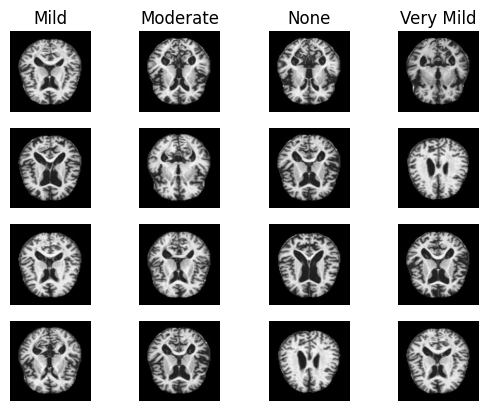

In [43]:
train_lab_idx = np.asarray(train.iloc[:].label)

f, ax = plt.subplots(4,4)
for lab in range(4):
    for ex in range(4):
    
        class_lab = np.argwhere(train_lab_idx == 1)
        current_idx = np.random.randint(len(class_lab)-1,size = 1)
        current_idx = np.asarray(current_idx)
        
        ax[ex, lab].axis('off')
        ax[ex, lab].imshow(train.iloc[class_lab[current_idx[0]][0]].img_arr, cmap = "gray")
        if ex == 0: ax[ex, lab].set_title(Lab[lab])

Clearly, images show different slices within the brain, which may be a major confound...

Explore distribution of dataset classes

Text(0, 0.5, '# of images')

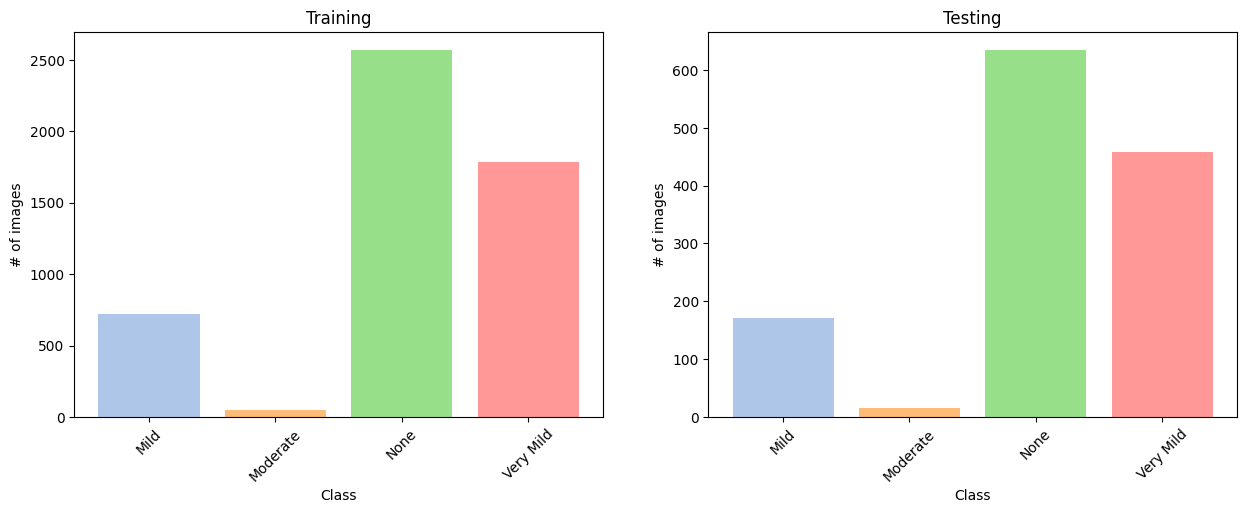

In [48]:
colors = ['#aec7e8', '#ffbb78', '#98df8a', '#ff9896']

f, ax = plt.subplots(1, 2, figsize=(15, 5))
unique, counts = np.unique(np.asarray(train.iloc[:].label), return_counts=True)
ax[0].bar(unique, counts, color=colors)
ax[0].set_xticks(unique)
ax[0].set_xticklabels(Lab, rotation=45)
ax[0].set_title('Training')
ax[0].set_xlabel('Class')
ax[0].set_ylabel('# of images')

unique, counts = np.unique(np.asarray(test.iloc[:].label), return_counts=True)
ax[1].bar(unique, counts, color=colors)
ax[1].set_xticks(unique)
ax[1].set_xticklabels(Lab, rotation=45)
ax[1].set_title('Testing')
ax[1].set_xlabel('Class')
ax[1].set_ylabel('# of images')

We can see that there is an obvious imbalance across classes in both the training and testing sets. However, each class has been proportionally split between the two. Nevertheless, let's attempt to balance the training set such that the model sees equal numbers of each class. To avoid overfitting (e.g. simple resampling), we use the SMOTE method here to synthetically generate new data based on what is available.

In [50]:
# Extract features and labels
X_train = np.array([img.flatten() for img in train['img_arr']])
y_train = train['label']

# Apply SMOTE
smote = SMOTE(random_state=42)
X_resampled, y_resampled = smote.fit_resample(X_train.reshape(-1, 128*128), y_train)

# Reshape the resampled data back to the original image shape
X_resampled = X_resampled.reshape(-1, 128, 128)

# Create a new DataFrame with the resampled data
train_resampled = pd.DataFrame({'label': y_resampled, 'img_arr': [img.tolist() for img in X_resampled]})

# Extract labels from the resampled training data
y_resampled = train_resampled['label']

# Plot the distribution of the different classes
colors = ['#aec7e8', '#ffbb78', '#98df8a', '#ff9896']

f, ax = plt.subplots(1, 1, figsize=(7, 5))
unique, counts = np.unique(y_resampled, return_counts=True)
ax.bar(unique, counts, color=colors)
ax.set_xticks(unique)
ax.set_xticklabels(Lab, rotation=45)
ax.set_title('Resampled Training')
ax.set_xlabel('Class')
ax.set_ylabel('# of images')

NameError: name 'SMOTE' is not defined

Now we see that the training set is balanced across classes. Let's inspect some of the new data for quality.

In [ ]:
first_indices = {}
for num in range(0, 4):
    first_index = next((i for i, x in enumerate(y_resampled[5121:], start=5121) if x == num), None)
    first_indices[num] = first_index

print(first_indices)

# Visualize the images from the first_indices values
f, ax = plt.subplots(1, 4, figsize=(20, 5))
for i, label in enumerate(np.unique(y_resampled)):
    if first_indices[label] is not None:
        first_image = np.array(train_resampled.iloc[first_indices[label]]['img_arr']).reshape(128, 128)
        ax[i].imshow(first_image, cmap='gray')
        ax[i].set_title(f"{Lab[label]}: SMOTE")
    ax[i].axis('off')